In [1]:
import numpy as np
import pysindy as ps
import networkx as nx
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [3]:
def bio(data, t):
    F = 5
    B = 1
    R = 1
    
    n = len(data)
    result = np.empty(n)
    
    for i in range(0,n):
        sigma = 0
        for j in range (0,n):
            sigma = sigma + R*(adjacency[i,j])*data[i]*data[j]
        result[i] = F - B*data[i] - sigma
    
    return result

In [47]:
number_of_nodes = 4
adjacency = np.array([
       [0., 0., 0., 1,],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]
])

dt = .02

t_train = np.arange(0, 10, dt)
x0_train = [-8, 8, 27, 5]
x_train = odeint(bio, x0_train, t_train)


library_functions = [
    lambda : 1,
    lambda x : x,
    lambda x,y : x*y
]
library_function_names = [
    lambda : 1,
    lambda x : x,
    lambda x,y : '' + x + '.' + y
]
custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

model = ps.SINDy(feature_library=custom_library)
model.fit(x_train, t=dt)
model.print()

x0' = 5.379 1 + -0.588 x1 + 0.861 x2 + -1.260 x3 + -0.003 x0.x1 + 0.006 x0.x2 + -0.997 x0.x3 + 0.010 x1.x2 + -0.142 x1.x3
x1' = 4.448 1 + 0.517 x0 + -8.801 x1 + -3.181 x2 + 4.362 x3 + 2.741 x0.x1 + -0.522 x0.x3 + 0.375 x1.x2
x2' = -9.860 1 + 7.559 x0 + -15.222 x1 + -8.985 x2 + 11.826 x3 + 2.700 x0.x1 + -1.624 x0.x3 + 0.392 x1.x2 + 4.304 x1.x3
x3' = 4.238 1 + -0.152 x0 + -0.655 x2 + -0.013 x0.x2 + -1.045 x0.x3 + 0.188 x1.x3


In [48]:
def find_steady_state(X):
    prev_state = X[0]
    for i in range(1,len(X)):
        state = X[i]
        max_diff = np.amax(np.subtract(state, prev_state))
        prev_state = state
        if max_diff < 0.0001:
            return state

real_steady_state = find_steady_state(x_train)        
        
def bio_sindy(data, t):
    # custom_library.get_feature_names()
    cf = [1, data[0], data[1], data[2], data[3], 
     data[0]*data[1], data[0]*data[2], data[0]*data[3],
     data[1]*data[2], data[1]*data[3], data[2]*data[3]]
    
    result = np.empty(len(data))
    for index in range(0, len(data)):
        sum = 0
        for i in range(0, len(cf)):
            sum += coefficients[index][i] * cf[i]
        result[index] = sum
    return result

coefficients = model.coefficients()
x_test = odeint(bio_sindy, x0_train, t_train)
sindy_steady_state = find_steady_state(x_test)

print('real_steady_state:', real_steady_state)
print('sindy_steady_state:', sindy_steady_state)

real_steady_state: [1.78790659 1.786349   1.79624565 1.79467798]
sindy_steady_state: [1.76711039 1.78264138 1.81015107 1.81240566]


In [49]:
perturbation = np.array([1., 0., 0., 0.])
perturbed = np.add(sindy_steady_state, perturbation)

t_perturbed = np.arange(0, 10, dt)
x_perturbed = odeint(bio_sindy, perturbed, t_perturbed)
perturbed_steady_state = find_steady_state(x_perturbed)

print('perturbed_steady_state:', perturbed_steady_state)

perturbed_steady_state: [1.77997345 1.79230681 1.80074295 1.80110508]


In [50]:
def flow(X):
    prev_state = X[0]
    result = np.empty((0,len(prev_state)))
    for i in range(1,len(X)):
        state = X[i]
        diff = np.subtract(state, prev_state)
        result = np.vstack((result, diff))
        prev_state = state
        if np.amax(diff) < 0.001:
            break
    return result

x_flow = flow(x_perturbed)
x_flow

array([[-0.03287346,  0.08150913,  0.16552055, -0.04051209],
       [-0.02709948,  0.06836013,  0.12450236, -0.03880484],
       [-0.02215827,  0.05771405,  0.09053847, -0.03702363],
       ...,
       [ 0.00050101,  0.00101754, -0.00085685, -0.00054555],
       [ 0.0004866 ,  0.00100083, -0.00084021, -0.00053125],
       [ 0.00047236,  0.00098414, -0.00082371, -0.00051713]])

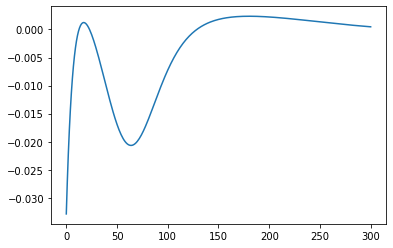

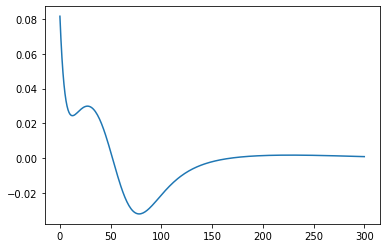

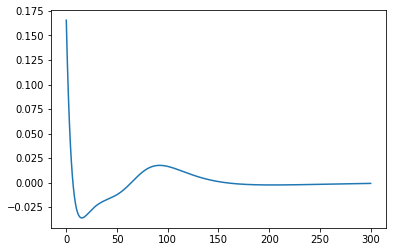

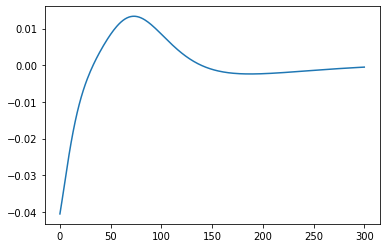

In [53]:
for i in range(0,number_of_nodes):
    plt.figure(i)
    plt.plot(x_flow[:,i])
plt.show()